In [ ]:
# Question
# Intent Classification for Customer Support Chats Scenario A company receives customer chat messages across multiple channels. We want to automatically classify user messages into specific intent categories to route them to the right team. Objective Build an RNN/LSTM model that classifies short text messages into predefined intent labels. Tasks 1. 1. Create a CSV with columns: text, label (≈500 rows). Example labels: order_status, refund_request, technical_issue, billing_query, general_info. 2. 2. Preprocess text (lowercase, remove punctuation, tokenize, pad). 3. 3. Build model: Embedding → LSTM → Dense(softmax). 4. 4. Train/validate and report accuracy + confusion matrix. 5. 5. Write a short note (6–8 lines): How automatic intent classification reduces support workload. Deliverables Notebook, sample CSV, short note.

In [1]:
pip install kaggle

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.4/164.4 KB 9.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
import urllib.request
import zipfile
import os

# Download Microsoft's sample cats and dogs dataset
url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"
filename = "cats_and_dogs.zip"

print("Downloading dataset...")
urllib.request.urlretrieve(url, filename)

# Extract
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall("dataset")

dataset_path = "dataset/PetImages"
print("Dataset downloaded and extracted!")

Dataset downloaded and extracted!


In [8]:
# Clean corrupted images from the dataset
import os
from PIL import Image

def clean_dataset(dataset_path):
    """Remove corrupted images from the dataset"""
    removed_count = 0
    
    for folder in ['Cat', 'Dog']:
        folder_path = os.path.join(dataset_path, folder)
        if not os.path.exists(folder_path):
            continue
            
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            try:
                # Try to open the image
                img = Image.open(file_path)
                img.verify()  # Verify it's a valid image
                img.close()
            except Exception as e:
                # Remove corrupted image
                print(f"Removing corrupted file: {file_path}")
                os.remove(file_path)
                removed_count += 1
    
    print(f"Cleaned {removed_count} corrupted images")

# Run this after downloading the dataset
dataset_path = "dataset/PetImages"
clean_dataset(dataset_path)

Removing corrupted file: dataset/PetImages/Cat/666.jpg
Removing corrupted file: dataset/PetImages/Cat/Thumbs.db
Removing corrupted file: dataset/PetImages/Dog/Thumbs.db
Removing corrupted file: dataset/PetImages/Dog/11702.jpg
Cleaned 4 corrupted images


/mnt/home/a442288/.local/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os

# Set dataset path
dataset_path = "dataset/PetImages"

# Image preprocessing with data augmentation
img_height, img_width = 150, 150
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_data = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_data = val_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

print(f"Training samples: {train_data.samples}")
print(f"Validation samples: {val_data.samples}")

Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.
Training samples: 20000
Validation samples: 4998


In [10]:
# Building teh cnn model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification (cat or dog)
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Train and evaluate the model
epochs = 10
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs
)


Epoch 1/10


625/625 ━━━━━━━━━━━━━━━━━━━━ 111s 177ms/step - accuracy: 0.5487 - loss: 0.6882 - val_accuracy: 0.5514 - val_loss: 0.6886
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 108s 172ms/step - accuracy: 0.6079 - loss: 0.6563 - val_accuracy: 0.6783 - val_loss: 0.5918
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 108s 173ms/step - accuracy: 0.6873 - loss: 0.5946 - val_accuracy: 0.7551 - val_loss: 0.5186
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 110s 176ms/step - accuracy: 0.7154 - loss: 0.5567 - val_accuracy: 0.7431 - val_loss: 0.5239
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 108s 173ms/step - accuracy: 0.7348 - loss: 0.5283 - val_accuracy: 0.6965 - val_loss: 0.6298
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 108s 172ms/step - accuracy: 0.7603 - loss: 0.5033 - val_accuracy: 0.8075 - val_loss: 0.4375
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 107s 172ms/step - accuracy: 0.7665 - loss: 0.4873 - val_accuracy: 0.8185 - val_loss: 0.4122
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 108s 173ms/step - accuracy: 0.7883 - loss: 0.45

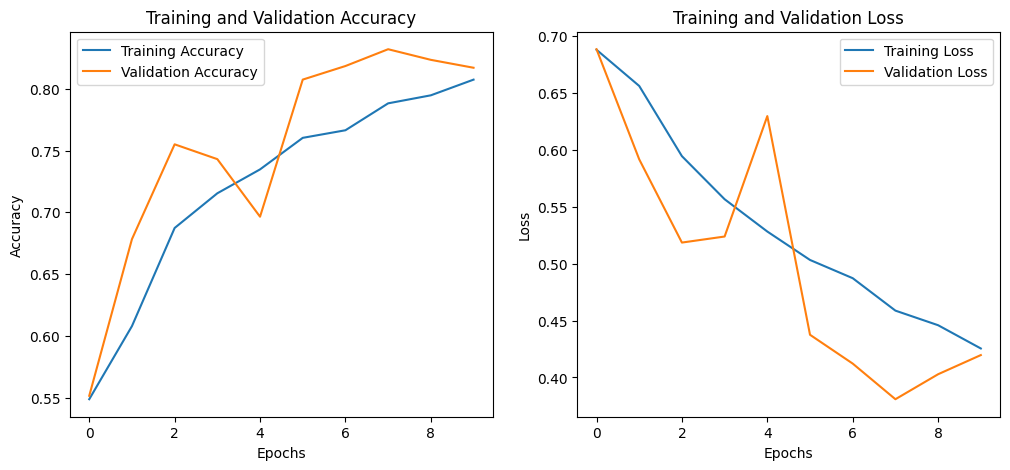

In [12]:
# Visualize training loss and accuracy
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [13]:
# Save the model
model.save("cats_vs_dogs_cnn_model.h5")

# Load the model
loaded_model = tf.keras.models.load_model("cats_vs_dogs_cnn_model.h5")

# Evaluate loaded model
loss, accuracy = loaded_model.evaluate(val_data)
print(f"Loaded Model Accuracy: {accuracy:.2f}")


157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.8171 - loss: 0.4196
Loaded Model Accuracy: 0.82
